In [437]:
# This is my implementation of Lanczos to approximate the SVD. I will be doing this to view MNIST images via PCA

In [438]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

In [439]:
def lanczos(A, k):
    r = A.shape[0]
    V = np.zeros((r,k))
    alphas = np.zeros(k)
    betas = np.zeros(k)
    v = np.random.rand(r)
    v = v/np.linalg.norm(v)
    b = 0
    v_previous = np.zeros(r).T
    for i in range(k):
        V[:,i] = v
        w = A.dot(v)
        a = np.dot(v, w)
        alphas[i] = a
        w = w - b*v_previous - a*v
        
        # Possible re-orthogonalization (serial)
        for t in range(i):
            temp_a = np.dot(V[:, t], w)
            if temp_a == 0.0:
                continue
            w -= temp_a * V[:, t]
        
        b = np.linalg.norm(w)
        betas[i] = b
        if b < np.finfo(float).eps:
            break
        v_previous = v
        v = (1/b)*w
    
    T = np.diag(alphas) + np.diag(betas[0:-1], k=1) + np.diag(betas[0:-1], k=-1)
    return T, V

In [440]:
def approx_svd(T, V, m, c):
    Eig_val, Eig_vec = np.linalg.eig(T)
    tempY = V@Eig_vec
    r = tempY.shape[0]
    
    count = 0
    vals = []
    Y_l = np.zeros((m, c))
    Y_r = np.zeros((r-m, c))
    
    for i in range(len(Eig_val)):
        if Eig_val[i] > 1e-12:
            Y_l[:, count] = tempY[-m:, i]
            Y_r[:, count] = tempY[0:r-m, i]
            vals.append(i)
            count += 1
            if count == c:
                break
    
    Y_l = normalize(Y_l.T, norm="l2").T
    Y_r = normalize(Y_r.T, norm="l2").T
    
    return Y_l, Eig_val, Y_r

In [441]:
def sym_data(X):
    # Create symmetric matrix S
    r,c = X.shape
    S = np.zeros((r+c, r+c))
    S[0:c, c:r+c] = X.T
    S[c:r+c, 0:c] = X
    return S

In [442]:
# Perform PCA on MNIST using Lanczos for a specific k
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_samples = train_X.shape[0]
test_samples = test_X.shape[0]
pixels = train_X.shape[1]*train_X.shape[2]
X = train_X.reshape(train_samples, pixels)

# for less space
#X = test_X.reshape(test_samples,pixels)
#labels = test_y.reshape(len(test_y),1)

# Even Smaller (to test appx SVD)
num = 20000
X = X[0:num,:]
labels = train_y[0:num].reshape(num,1)
m, n = X.shape

#standardize data
X = StandardScaler().fit_transform(X)

# Create symmetric version of data
S = sym_data(X)

In [452]:
# 3D PCA Computations (Will use for 2D as well)
k = 60
appx = 3
t3d = time.time()
T, V = lanczos(S, k)
U, D, Vt = approx_svd(T, V, m, appx)
elapsed_t3d = time.time() - t3d
proj_X = X@Vt
data = np.append(proj_X, labels, axis = 1)
df = pd.DataFrame(data, columns=["x", "y", "z", "Digit"])
df.sort_values('Digit', axis=0, ascending=True, inplace=True)
df["Digit"] = df["Digit"].astype(str)

In [453]:
# 3D PCA Plot
fig = px.scatter_3d(df, x = "x", y = "y", z = "z", color = "Digit")
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()

In [454]:
# 2D PCA Plot
fig = px.scatter(df, x = "x", y = "y", color = "Digit")
fig.update_traces(mode='markers', marker_size=3)
fig.show()

In [446]:
# Time the difference between computing true SVD and approximate SVD via Lanczos
tsvd = time.time()
Ux, Sx, Vx = np.linalg.svd(X)
elapsed_tsvd = time.time() - tsvd

In [455]:
# Compare the differences in runtime
print('Computational Time for Approximate SVD via Lanczos:')
print(elapsed_t3d)
print('Computational Time for True SVD:')
print(elapsed_tsvd)

Computational Time for Approximate SVD via Lanczos:
16.33587145805359
Computational Time for True SVD:
137.09969115257263


In [448]:
# Compare values of k (to determine how varying k affects accuracy)
k_vals = np.linspace(0,150, 16).astype(int)
k_vals[0] = 1

times = np.zeros((k_vals.shape[0],1))
errors_inf = np.zeros((k_vals.shape[0],1))
errors_2norm = np.zeros((k_vals.shape[0],1))
dim = 3

count = 0
for k in k_vals:
    t3dk = time.time()
    Tk, Vk = lanczos(S, k)
    Uk, Dk, Vk = approx_svd(Tk, Vk, m, dim)
    elapsed_t3dk = time.time() - t3dk
    print('Run for k = %d is Complete!' %k)
    times[count] = elapsed_t3dk
    errors_inf[count] = np.linalg.norm(abs(Vk) - abs(Vx.T[:,0:dim]), np.inf)
    errors_2norm[count] = np.linalg.norm(abs(Vk) - abs(Vx.T[:,0:dim]))
    count += 1

Run for k = 1 is Complete!
Run for k = 10 is Complete!
Run for k = 20 is Complete!
Run for k = 30 is Complete!
Run for k = 40 is Complete!
Run for k = 50 is Complete!
Run for k = 60 is Complete!
Run for k = 70 is Complete!
Run for k = 80 is Complete!
Run for k = 90 is Complete!
Run for k = 100 is Complete!
Run for k = 110 is Complete!
Run for k = 120 is Complete!
Run for k = 130 is Complete!
Run for k = 140 is Complete!
Run for k = 150 is Complete!


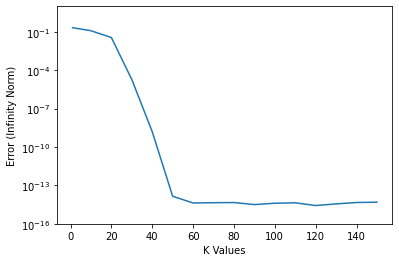

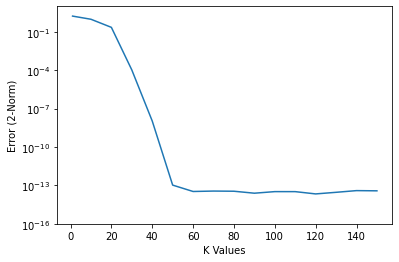

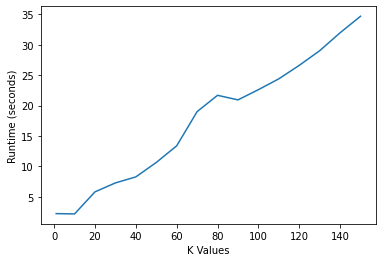

In [449]:
fig1 = plt.figure()
plt.plot(k_vals, errors_inf)
plt.xlabel('K Values')
plt.ylabel('Error (Infinity Norm)')
plt.yscale('log')
plt.ylim([1e-16, 10])
plt.show()

fig2 = plt.figure()
plt.plot(k_vals, errors_2norm)
plt.xlabel('K Values')
plt.ylabel('Error (2-Norm)')
plt.yscale('log')
plt.ylim([1e-16, 10])
plt.show()

fig3 = plt.figure()
plt.plot(k_vals, times)
plt.xlabel('K Values')
plt.ylabel('Runtime (seconds)')
plt.show()

In [450]:
# TO DO:
# Parallelize
# Test on multivariate Gaussian

# Test
#A = np.random.rand(50,20)
#H = sym_data(A)
#T, V = lanczos(H, 10)
#Yl, D, Yr = approx_svd(T, V, 50, 2)

#U,D2,Vh = np.linalg.svd(A)

#print('============')
#print(Yr[0:10,:])
#print('============')
#print(Vh.T[0:10,0:2])
#print('============')
#print(Yl[0:10,:])
#print('============')
#print(U[0:10,0:2])

In [451]:
tpca = time.time()
pca = PCA(n_components=3)
pca.fit(X)
X2 = pca.transform(X)
elapsed_pca = time.time() - tpca

print(elapsed_pca)


2.1473138332366943
